# Bipedal Walker Reinforcement Learning Project

**Syed Ali Haider**



## Introduction

This notebook explores the Bipedal Walker environment and demonstrates the training of an A2C reinforcement learning agent to solve it. It includes steps for environment setup, agent training, evaluation, and visualization of results.

## Environment Setup

This section outlines the process of setting up the necessary libraries and environments for the project.

In [ ]:
%%capture
!pip install swig
!pip install gymnasium[box2d]==0.28.1
!pip install "stable-baselines3[extra]==2.0.0"
!rm rltools -r
!git clone https://github.com/drbeane/rltools.git

## Project Dependencies

This cell imports the required libraries for this project, including:
* **Gymnasium:** Provides the Bipedal Walker environment.
* **rltools:** A custom library for reinforcement learning utilities.
* **Stable Baselines3:** A library for reinforcement learning algorithms.
* **NumPy, Pandas, Matplotlib:** Libraries for data manipulation and visualization.

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rltools.gym as gym
from rltools.utils import RandomAgent, SB3Agent, sb3_evaluation_curves
from rltools.utils import create_gif, evaluate

from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecNormalize

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


## Project Dependencies

This cell imports the required libraries for this project, including:
* **Gymnasium:** Provides the Bipedal Walker environment.
* **rltools:** A custom library for reinforcement learning utilities.
* **Stable Baselines3:** A library for reinforcement learning algorithms.
* **NumPy, Pandas, Matplotlib:** Libraries for data manipulation and visualization.

## Hardware Acceleration (Optional)

While the notebook can be run on CPU, GPU acceleration can significantly speed up training in Part 2, especially for the A2C agent.

**Note:**  Utilizing a GPU is optional and depends on the available hardware.

# Part 1: Bipedal Walker Environment Exploration

This section focuses on understanding the Bipedal Walker environment through visualization and analysis of its state and action spaces.

## Environment Initialization

A Bipedal Walker environment is created, and its initial state is visualized.

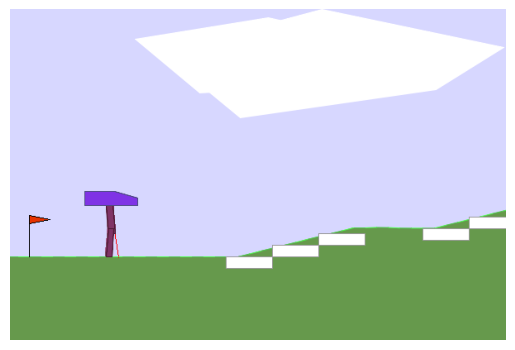

In [ ]:
envA = gym.make("BipedalWalker-v3", hardcore=True, render_mode="rgb_array")

state,info = envA.reset(seed = 1)
plt.imshow(envA.render())
plt.axis('off')
plt.show()


## Action and Observation Spaces

This section examines the structure of the action and observation spaces of the Bipedal Walker environment. Both spaces are continuous, meaning they are represented by arrays of floating-point values.

In [ ]:
print(envA.observation_space.shape)
print(envA.action_space.shape)

(24,)
(4,)


## State Array Representation

The initial state of the environment is displayed. This array contains 24 values that represent various aspects of the Bipedal Walker's state, including its position, velocity, joint angles, and lidar readings.

In [ ]:
print(state,'\n',
state.shape)

[ 2.74756202e-03 -1.57684258e-06  1.22662866e-04 -1.59999914e-02
  9.21287537e-02 -1.61870528e-04  8.60172093e-01  1.52297970e-03
  1.00000000e+00  3.25347967e-02 -1.61864329e-04  8.53720844e-01
  1.14479735e-04  1.00000000e+00  4.40813929e-01  4.45820034e-01
  4.61422682e-01  4.89550084e-01  5.34102678e-01  6.02460921e-01
  7.09148765e-01  8.85931671e-01  1.00000000e+00  1.00000000e+00] 
 (24,)


## Action Array Representation

A random action is sampled and displayed, demonstrating the structure of the action space. The action array consists of 4 values, each controlling the motor speed of one of the Bipedal Walker's joints.

In [ ]:
envA.action_space.sample()

array([ 0.70015055, -0.6303201 ,  0.24883929,  0.9385736 ], dtype=float32)

## Random Agent Performance

A random agent is evaluated in the Bipedal Walker environment to establish a baseline performance level. This helps assess the effectiveness of more sophisticated agents later on.

In [ ]:
agentRa = RandomAgent(envA, seed = 1)
evaluate(env=envA, agent=agentRa,gamma=1.0,episodes=50,seed=1, max_steps=1000)

Mean Return:    -88.0178
StdDev Return:  26.4921
Mean Length:    369.64
StdDev Length:  432.84


{'mean_return': -88.01781905207066,
 'stdev_return': 26.492076695389148,
 'mean_length': 369.64,
 'stdev_length': 432.8399593383217}

## Random Agent Behavior Visualization

These visualizations show the behavior of the random agent in the Bipedal Walker environment across different episodes. The selected episodes highlight variations in the agent's performance, from short sprints to longer attempts at navigation.

84 steps completed.
Cumulative reward: -104.2111


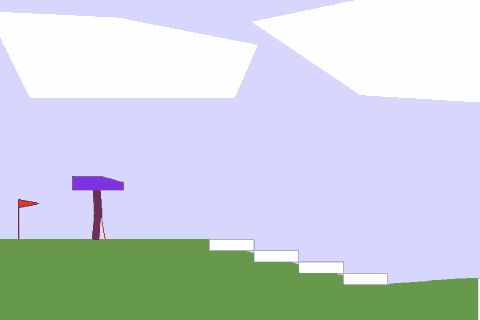

In [ ]:
randomSprint = create_gif(envA, agentRa, max_steps=1000, seed=429, folder='gifs', filename='randsprint', scale = .8, num_colors = 8)

1000 steps completed.
Cumulative reward: -52.0631


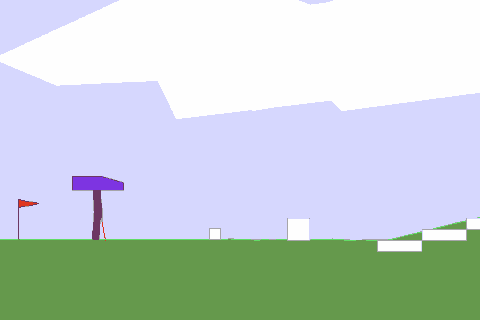

In [ ]:
randomMarathon = create_gif(envA, agentRa, max_steps=1000, seed=2, folder='gifs', filename='randmarathon', scale = .8, num_colors = 8)

# Part 2: Training an A2C Agent

This section focuses on training an A2C (Advantage Actor-Critic) agent to solve the Bipedal Walker environment, leveraging reinforcement learning techniques.

## Training and Evaluation Environments

This section sets up the environments for training and evaluating the A2C agent. Vectorized environments are used to improve training efficiency. State normalization is applied to improve stability and performance. A separate test environment is used for final agent evaluation.

(16, 24)


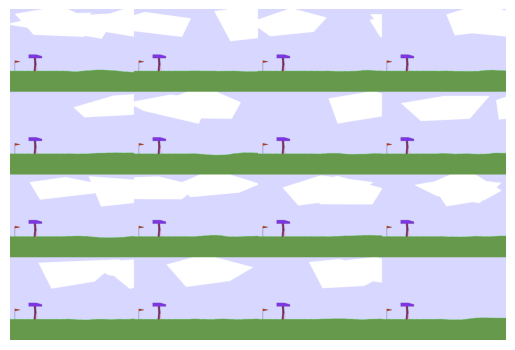

In [ ]:
texasranger_vec_base_env_unnorm = make_vec_env(env_id='BipedalWalker-v3', n_envs=16, seed=0)
texasranger_vec_eval_env_unnorm = make_vec_env(env_id='BipedalWalker-v3', n_envs=16, seed=0)
texasranger_vec_base_env = VecNormalize(texasranger_vec_base_env_unnorm,norm_obs=True, norm_reward = False, clip_obs = 10.0)
texasranger_vec_eval_env = VecNormalize(texasranger_vec_eval_env_unnorm,norm_obs=True, norm_reward = False, clip_obs = 10.0)
texasranger_test_env = gym.make('BipedalWalker-v3', render_mode='rgb_array')

state = texasranger_vec_base_env.reset()
print(state.shape)

plt.imshow(texasranger_vec_base_env.render())
plt.axis('off')
plt.show()

## Evaluation Callback Configuration

An evaluation callback is configured to monitor the agent's progress during training. The callback periodically evaluates the agent on a separate evaluation environment and saves the best performing model.

In [ ]:
if os.path.exists('walker_evaluation/') : shutil.rmtree('walker_evaluation/')
texasranger_eval_callback = EvalCallback(
    texasranger_vec_eval_env, best_model_save_path="walker_evaluation/", log_path="walker_evaluation/",
    n_eval_episodes=20, eval_freq=1000, warn=False)

## A2C Model Training

An A2C agent is created and trained using the specified hyperparameters. The training process involves interactions with the environment and updates to the agent's policy and value function. The model's performance is continuously monitored and the best model is saved.

In [ ]:
%%time

def linear_schedule(initial_lr, final_lr):
    def sched_func(progress_remaining):
        return final_lr + progress_remaining * (initial_lr - final_lr)
    return sched_func

model = A2C(
    policy = 'MlpPolicy',
    env = texasranger_vec_base_env,

    learning_rate = linear_schedule(9.1e-4,7.6e-4),
    n_steps = 8,
    gae_lambda = 0.95,
    vf_coef = 0.4,
    normalize_advantage = False,
    use_sde = True,
    policy_kwargs = dict(log_std_init=-2, ortho_init=False),

    verbose=0,
    seed=3486,
)

model = model.learn(total_timesteps=2_000_000, progress_bar=False, callback=texasranger_eval_callback)

Eval num_timesteps=16000, episode_reward=-126.33 +/- 8.34
Episode length: 229.85 +/- 52.97
Eval num_timesteps=32000, episode_reward=-47.65 +/- 15.95
Episode length: 1544.70 +/- 241.05
Eval num_timesteps=48000, episode_reward=-70.06 +/- 10.78
Episode length: 1600.00 +/- 0.00
Eval num_timesteps=64000, episode_reward=-99.16 +/- 0.62
Episode length: 127.35 +/- 16.69
Eval num_timesteps=80000, episode_reward=-102.36 +/- 11.85
Episode length: 249.15 +/- 82.68
Eval num_timesteps=96000, episode_reward=-93.82 +/- 13.43
Episode length: 314.10 +/- 313.76
Eval num_timesteps=112000, episode_reward=-96.18 +/- 2.37
Episode length: 104.45 +/- 21.67
Eval num_timesteps=128000, episode_reward=-109.40 +/- 0.80
Episode length: 64.40 +/- 1.20
Eval num_timesteps=144000, episode_reward=-90.74 +/- 8.52
Episode length: 192.15 +/- 155.73
Eval num_timesteps=160000, episode_reward=-90.43 +/- 36.09
Episode length: 299.00 +/- 365.14
Eval num_timesteps=176000, episode_reward=-112.34 +/- 0.74
Episode length: 66.60 +/- 

## Evaluation Results Visualization

The training progress of the A2C agent is visualized by plotting the evaluation scores over time. This allows for analysis of the agent's learning curve and convergence towards optimal performance.

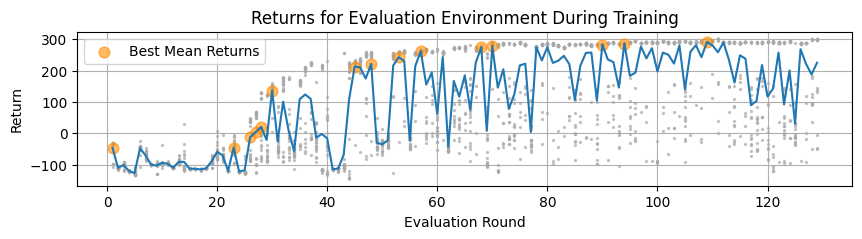

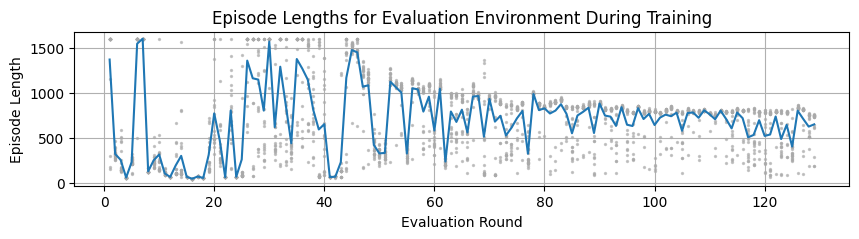

In [ ]:
sb3_evaluation_curves(path='walker_evaluation/')

## Best Model Evaluation

The best performing A2C model is loaded and evaluated on a separate test environment. This provides a final assessment of the agent's performance on unseen data, reflecting its generalization capabilities.

In [ ]:
best_model = A2C.load('walker_evaluation/best_model.zip', env=texasranger_test_env,)
chuckNorris = SB3Agent(best_model,normalizer=texasranger_vec_base_env.normalize_obs)
_ = evaluate(texasranger_test_env, chuckNorris, gamma=1.0, episodes=50, max_steps=1000, seed=1)

Mean Return:    230.6165
StdDev Return:  121.6781
Mean Length:    704.18
StdDev Length:  208.6492


## A2C Agent Behavior Visualization

This visualization showcases the behavior of the trained A2C agent in the Bipedal Walker environment. The selected episode demonstrates the agent's ability to successfully navigate the terrain and achieve a high cumulative reward.

781 steps completed.
Cumulative reward: 292.9833


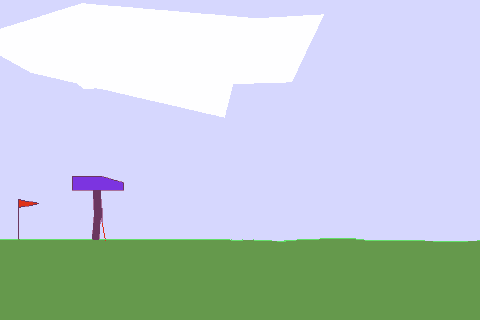

In [ ]:
cordellWalker = create_gif(texasranger_test_env, chuckNorris, max_steps=1000, seed=20, folder='gifs', filename='cordellWalker', scale = .8, num_colors = 8)